## Imports

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Packages Imported!")

Packages Imported!


## Settings

In [2]:
MANIFEST_PATH = "D:/datasets/allen_vc/manifest.json"
PROJECT_PATH = "D:/visual_encoding"
REPO_PATH = 'C:/Users/User/visual_encoding'
# REPO_PATH = 'C:/Users/micha/projects/visual_encoding'
DATA_PATH = "D:/visual_encoding/data/optotagging_data/concat"

In [3]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')

## Functions

In [4]:
def plot_clustering_results(X, gm, idx_plt=[0,1]):
    feats = X.columns.to_list()
    preds = gm.predict(X) 
    _, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X[feats[idx_plt[0]]], X[feats[idx_plt[1]]], c=preds, s=10, cmap='viridis')
    for ii in range(gm.n_components):
        plt.scatter(gm.means_[ii, idx_plt[0]], gm.means_[ii, idx_plt[1]], color='r', s=100)
    ax.set(xlabel=feats[idx_plt[0]].replace('_',' '), ylabel=feats[idx_plt[1]].replace('_',' '))
    plt.show()


## Load Data

In [5]:
# # Create Allensdk cache object
# cache = EcephysProjectCache.from_warehouse(manifest=MANIFEST_PATH)

# # Isolate functional connectivity sections
# sessions = cache.get_session_table()
# functional_connectivity_sessions = sessions[sessions['session_type'] == 'functional_connectivity']

In [6]:
# load optotagging response data
opto_df = pd.read_csv(f'{DATA_PATH}/tagged.csv')
opto_df.head()

,unit_id,genotype,stim_level,n_activated,tagged
0,950922446,wt/wt,12,0,False
1,950922495,wt/wt,12,0,False
2,950922511,wt/wt,12,0,False
3,950922546,wt/wt,12,0,False
4,950922579,wt/wt,12,0,False


In [7]:
# load spike waveform data
all_unit_waveforms_df = pd.read_pickle('D:/visual_encoding/data/waveforms/all_units.pkl')
all_unit_waveforms_df.head()

,unit_id,waveform_repolarization_slope,waveform_velocity_above,waveform_duration,waveform_velocity_below,waveform_halfwidth,waveform_spread,waveform_recovery_slope,waveform_amplitude,mean_isi,mean_wv_times,mean_wv_values,session_id
0,950911624,0.666637,0.412060,0.247236,0.000000,0.137353,60.0,-0.115895,156.94965,0.112076,"[0.0, 3.3333368334807866e-05, 6.66667366696157...","[0.0, -1.1590800000000006, -1.6512600000000006...",766640955
1,950911641,0.494906,-0.343384,0.219765,0.068677,0.109883,60.0,-0.085105,144.38775,0.104910,"[0.0, 3.3333368334807866e-05, 6.66667366696157...","[0.0, -0.8845199999999993, -1.2725699999999995...",766640955
2,950911686,0.554810,0.686767,0.247236,0.000000,0.109883,30.0,-0.080528,132.55983,0.052577,"[0.0, 3.3333368334807866e-05, 6.66667366696157...","[0.0, -0.6778199999999998, -1.0471500000000007...",766640955
3,950911657,0.454659,0.343384,0.412060,0.068677,0.137353,70.0,-0.060789,108.66375,0.137380,"[0.0, 3.3333368334807866e-05, 6.66667366696157...","[0.0, -0.4032600000000013, -1.12515, -1.692990...",766640955
4,950911696,0.779000,0.000000,0.178559,-0.608279,0.123618,100.0,-0.220320,186.91374,0.122068,"[0.0, 3.3333368334807866e-05, 6.66667366696157...","[0.0, -0.9044099999999942, -1.4465100000000035...",766640955


In [8]:
# join dfs on units
rwv_df = opto_df.merge(all_unit_waveforms_df, how='inner', on='unit_id')

print(f"Shape\t{rwv_df.shape}")
rwv_df.head()

Shape	(1679, 17)


,unit_id,genotype,stim_level,n_activated,tagged,waveform_repolarization_slope,waveform_velocity_above,waveform_duration,waveform_velocity_below,waveform_halfwidth,waveform_spread,waveform_recovery_slope,waveform_amplitude,mean_isi,mean_wv_times,mean_wv_values,session_id
0,950922446,wt/wt,12,0,False,0.196397,1.648241,0.837856,0.000000,0.233501,70.0,-0.017755,82.695990,0.162727,"[0.0, 3.333334349708743e-05, 6.666668699417486...","[0.0, 0.6830849999999998, 0.4758000000000001, ...",771160300
1,950922495,wt/wt,12,0,False,0.189410,0.206030,0.865327,-0.343384,0.247236,60.0,-0.015247,75.754965,1.453777,"[0.0, 3.333334349708743e-05, 6.666668699417486...","[0.0, -0.639404999999998, -0.01053000000000015...",771160300
2,950922511,wt/wt,12,0,False,0.196521,0.892797,0.975209,-1.030151,0.219765,60.0,-0.005732,101.102820,0.677403,"[0.0, 3.333334349708743e-05, 6.666668699417486...","[0.0, 0.4352400000000006, 0.5539949999999999, ...",771160300
3,950922546,wt/wt,12,0,False,0.337895,0.343384,0.782915,0.274707,0.192295,60.0,-0.020037,123.288945,0.559018,"[0.0, 3.333334349708743e-05, 6.666668699417486...","[0.0, -0.013650000000000051, -0.38648999999999...",771160300
4,950922579,wt/wt,12,0,False,0.335487,2.541039,0.618090,0.343384,0.219765,60.0,-0.069469,126.942465,0.348328,"[0.0, 3.333334349708743e-05, 6.666668699417486...","[0.0, -0.1755000000000011, -0.0746850000000014...",771160300


In [9]:
# check for NaN
rwv_df.isna().sum()

unit_id                           0
genotype                          0
stim_level                        0
n_activated                       0
tagged                            0
waveform_repolarization_slope     0
waveform_velocity_above          26
waveform_duration                 0
waveform_velocity_below          38
waveform_halfwidth               13
waveform_spread                   0
waveform_recovery_slope           8
waveform_amplitude                0
mean_isi                          0
mean_wv_times                     0
mean_wv_values                    0
session_id                        0
dtype: int64

In [10]:
# drop nan
rwv_df.dropna(inplace=True)
print(rwv_df.shape)

(1598, 17)


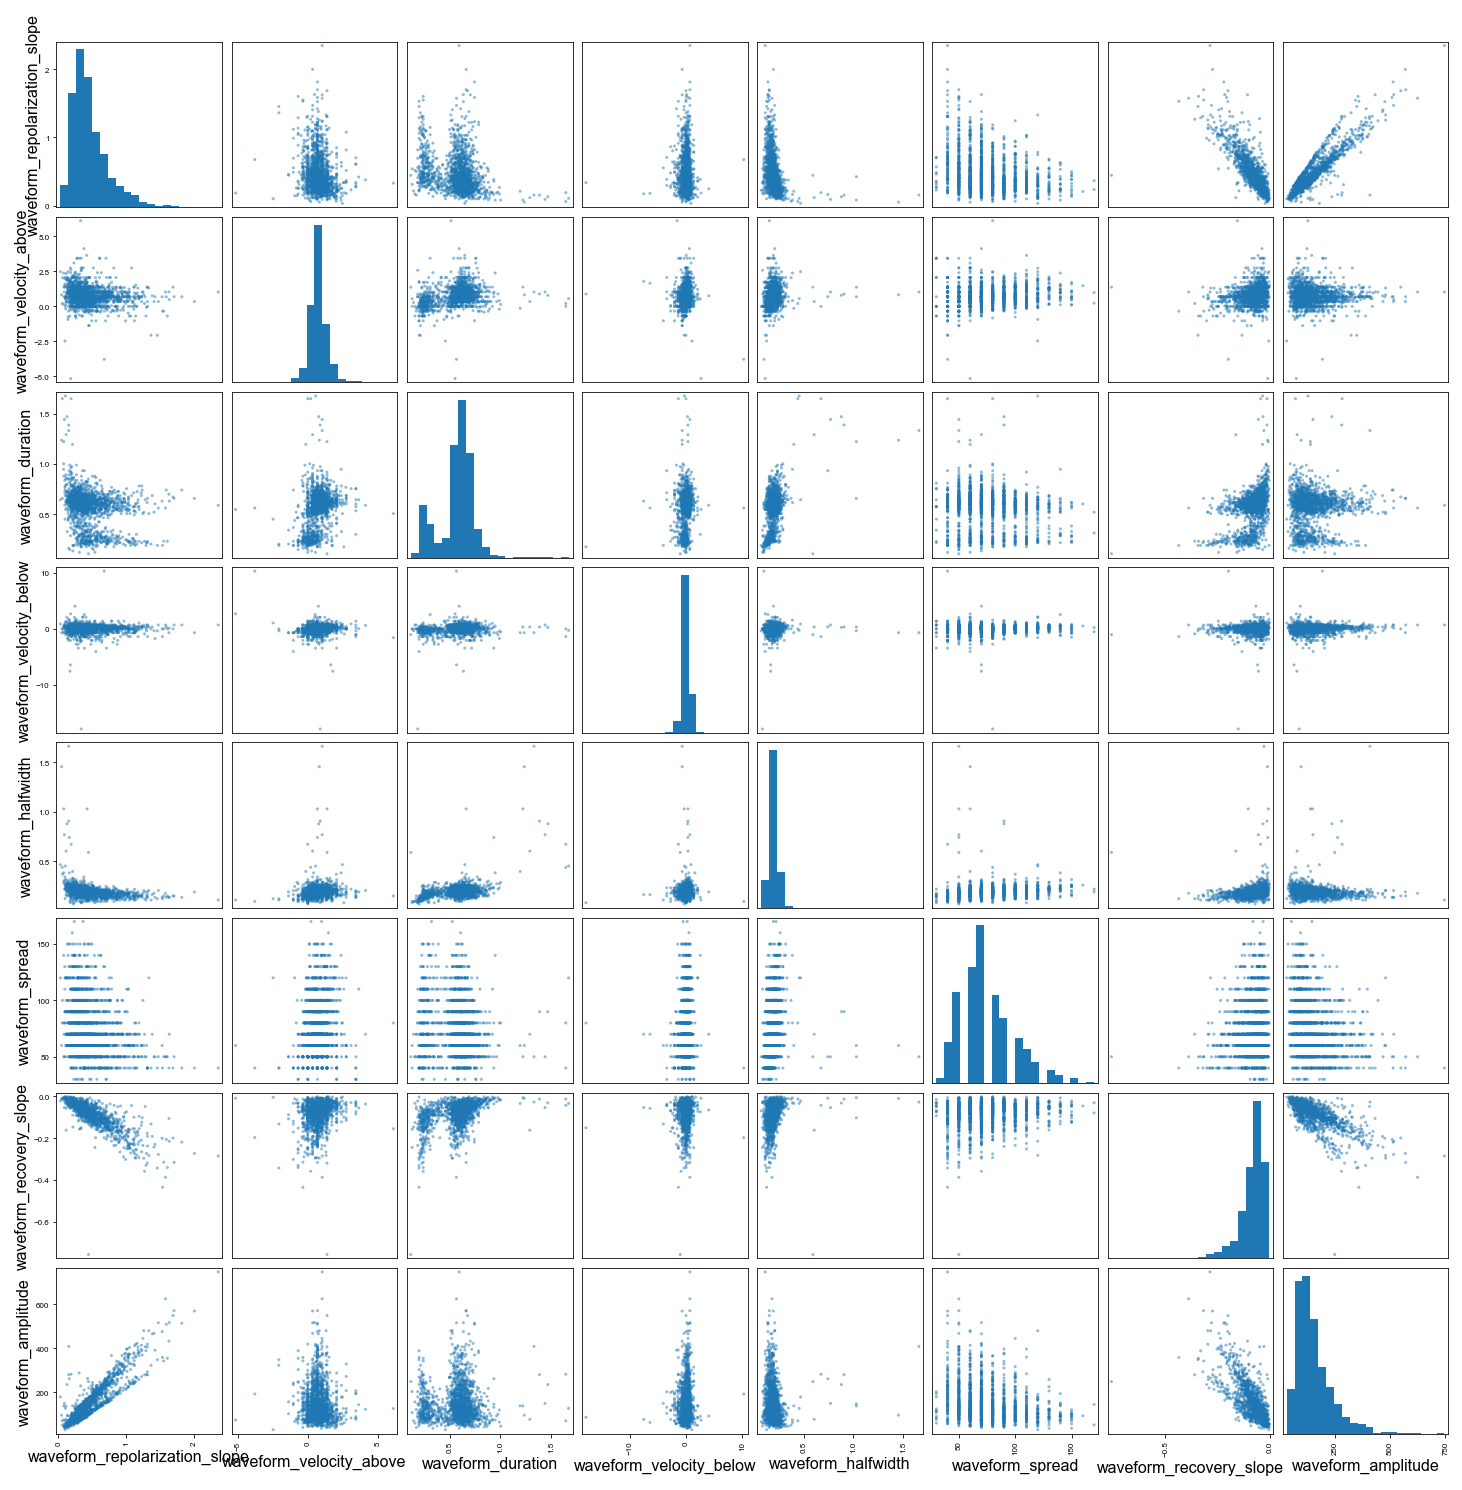

In [11]:
# plot scatter matrix
waveform_features = ['waveform_repolarization_slope',
       'waveform_velocity_above', 'waveform_duration',
       'waveform_velocity_below', 'waveform_halfwidth', 'waveform_spread',
       'waveform_recovery_slope', 'waveform_amplitude']

pd.plotting.scatter_matrix(rwv_df[waveform_features], figsize=(20,20), hist_kwds={'bins':20});

In [12]:
rwv_df.columns

Index(['unit_id', 'genotype', 'stim_level', 'n_activated', 'tagged',
       'waveform_repolarization_slope', 'waveform_velocity_above',
       'waveform_duration', 'waveform_velocity_below', 'waveform_halfwidth',
       'waveform_spread', 'waveform_recovery_slope', 'waveform_amplitude',
       'mean_isi', 'mean_wv_times', 'mean_wv_values', 'session_id'],
      dtype='object')

In [13]:
# save to csv
# rwv_df.to_csv(f'G:/Shared drives/visual_encoding/data/optotagging_data/concat/rr_wave_{stim}.csv', index=False)

# Clustering

In [14]:
# settings
clust_set = {'n_components': 2, 'random_state': 0, 'verbose': 1}

In [15]:
# initiailize model
gm = GaussianMixture(**clust_set)

In [16]:
# fit GMM

# pick features
# feats = ['waveform_duration', 'waveform_amplitude']
feats = waveform_features.copy()

# fit model
X = rwv_df[feats]
gm.fit(X)
preds = gm.predict(X)

# print results
print(f"\nBaysian Information Criterion: {gm.bic(X)}")
print(f"\nMeans:\n{gm.means_}")
gm

Initialization 0
Initialization converged: True

Baysian Information Criterion: 21144.155561101386

Means:
[[ 3.96186674e-01  8.10993390e-01  5.81577522e-01 -1.14341318e-02
   1.94044290e-01  7.69536126e+01 -6.61981094e-02  1.33254295e+02]
 [ 8.18593408e-01  5.00678298e-01  4.85939921e-01 -3.14316662e-02
   2.03259495e-01  6.60490040e+01 -1.56430016e-01  2.50783658e+02]]


GaussianMixture(n_components=2, random_state=0, verbose=1)

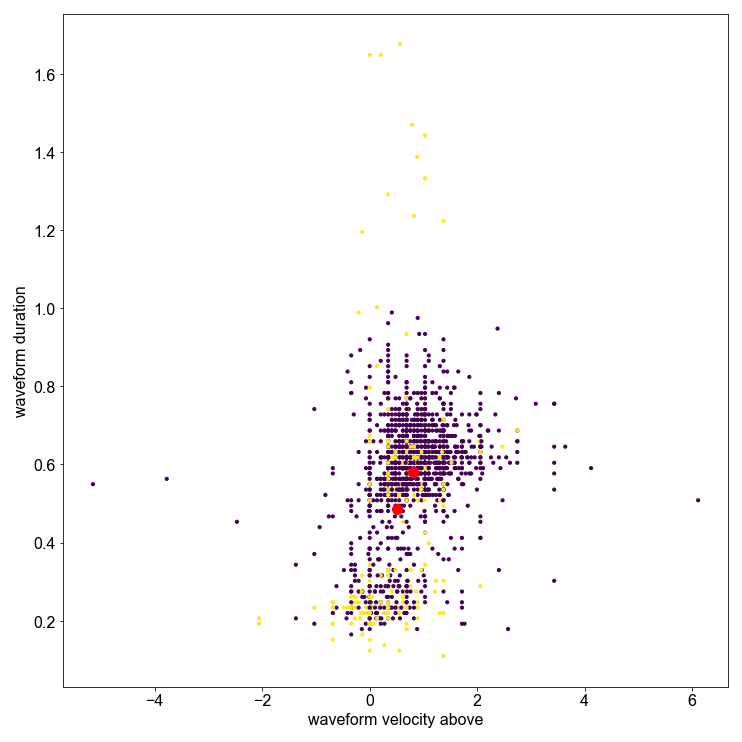

In [17]:
# plot clustering results
plot_clustering_results(X, gm, idx_plt=[1,2])

In [18]:
# fit number of components to all data
max_comp = 15
X = rwv_df[waveform_features]
clust_set['verbose'] = False

bics = []
for i in range(1, max_comp):
    
    clust_set['n_components'] = i
    gm = GaussianMixture(**clust_set)
    gm.fit(X)
    
    bics.append(gm.bic(X))

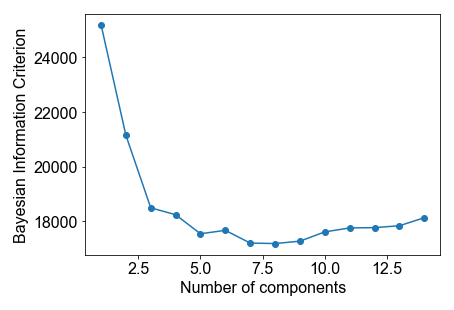

In [19]:
# plot BIC v # components
n_comp = range(1, max_comp)

plt.plot(n_comp, bics)
plt.scatter(n_comp, bics)

plt.xlabel('Number of components')
plt.ylabel('Bayesian Information Criterion');

In [20]:
# find minimum
n_comp = range(1, max_comp)
min_bic = n_comp[np.argmin(bics)]
print(f"Number of components with minimum BIC: {min_bic}")

Number of components with minimum BIC: 8


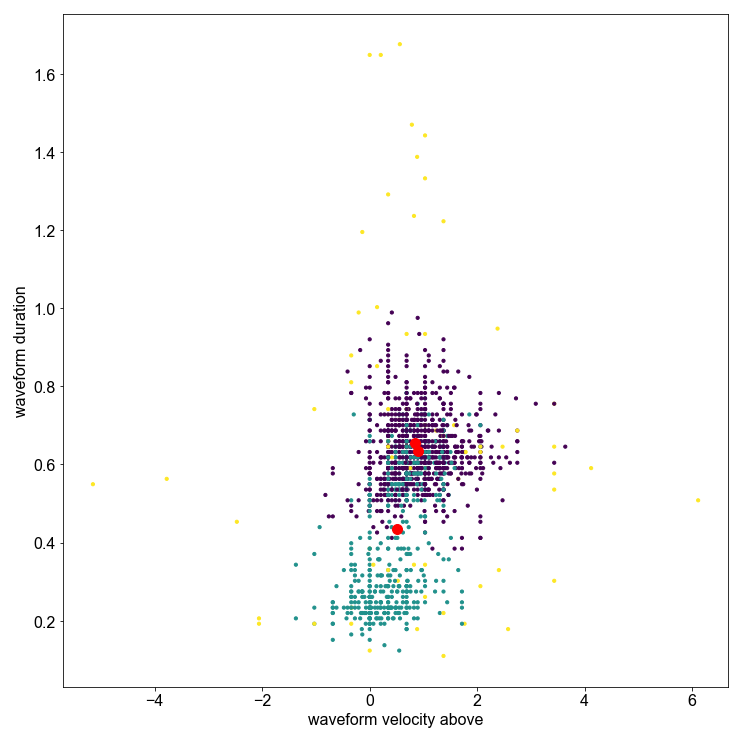

In [21]:
# fit with min_bic components
clust_set['n_components'] = 3 # min_bic
gm = GaussianMixture(**clust_set)
gm.fit(X)
plot_clustering_results(X, gm, idx_plt=[1,2])

In [22]:
# add cluster_num to dataframe
preds = gm.predict(X)
rwv_df['cluster_num'] = preds

In [23]:
# helper funcs

def genetic_resp(df):
    
    for gt in df['genotype'].unique():
        
        gdf = df[df['genotype'] == gt]
        print(f'\t{gdf.tagged.sum()} / {gdf.shape[0]} {gt} positive units')
    
    
def avg_wvf(df, ax=None):
    
    wvs = np.stack(df['mean_wv_values']) # can easily be changed to plot all waveforms
    avg_wv = np.mean(wvs, axis=0)
    std = np.std(wvs, axis=0)
    t = df['mean_wv_times'].iloc[0]
    
    ax.plot(t * 1000, avg_wv, 'k')
    ax.fill_between(t * 1000, avg_wv - std, avg_wv + std, alpha=0.3) # plot shaded standard dev
             

Cluster 0: 


	2 / 586 wt/wt positive units
	4 / 236 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	1 / 85 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 69 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units



Cluster 1: 


	6 / 294 wt/wt positive units
	11 / 142 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	14 / 56 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 58 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units



Cluster 2: 


	0 / 43 wt/wt positive units
	1 / 16 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	1 / 7 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 6 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units





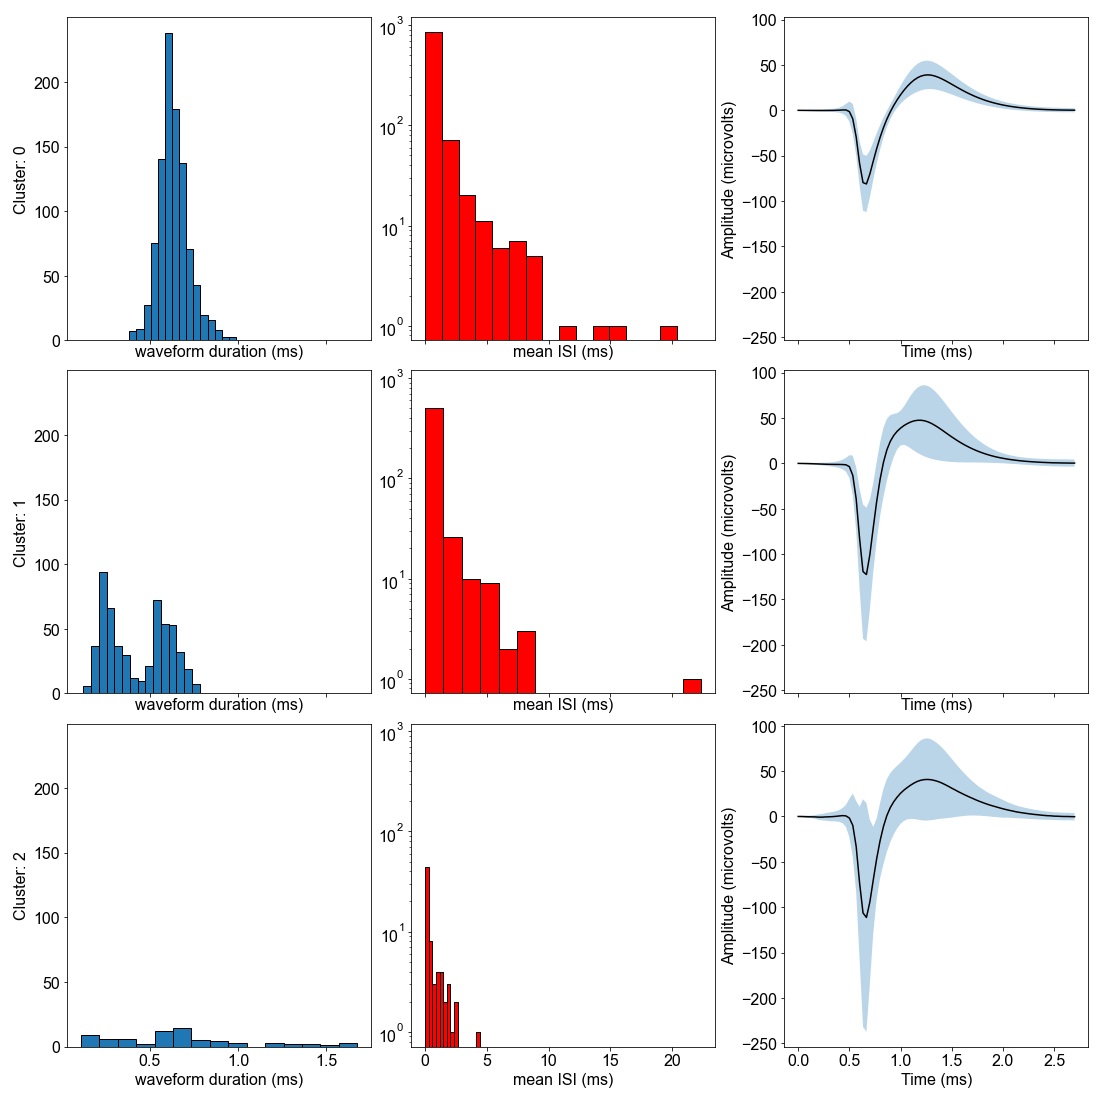

In [24]:
# for each cluster, visualize waveform_duration dist and count responsive units
clusters = rwv_df['cluster_num'].unique()

fig, ax = plt.subplots(3,3, sharex='col', sharey='col', figsize=(15,15))

for i, cluster in enumerate(clusters):
    print(f'Cluster {cluster}: \n\n')
    
    clust_df = rwv_df[rwv_df['cluster_num'] == cluster]
    
    # count number responded for each genotype
    genetic_resp(clust_df)
    
    # plot waveform_duration and mean ISI distribution
    ax[i, 0].hist(clust_df['waveform_duration'], edgecolor='black', bins=15)
    ax[i, 0].set_xlabel('waveform duration (ms)')
    
    ax[i, 1].hist(clust_df['mean_isi'], color= 'red', edgecolor='black', bins=15)
    ax[i, 1].set_xlabel('mean ISI (ms)')
    ax[i, 1].set_yscale('log')
    
    # compute avg waveform across units
    avg_wvf(clust_df, ax[i, 2])
    ax[i, 2].set_xlabel('Time (ms)')
    ax[i, 2].set_ylabel('Amplitude (microvolts)')
    
    ax[i, 0].set_ylabel(f"Cluster: {cluster}")
    
    print('\n\n')
    

Based on this particular clustering analysis it appears that cluster 0 may correspond to excitatory units with lower optotagging response rates and longer waveform durations whereas cluster 1 likely corresponds to inhibitory units with higher optotagging response rates and shorter wavefrom durations.

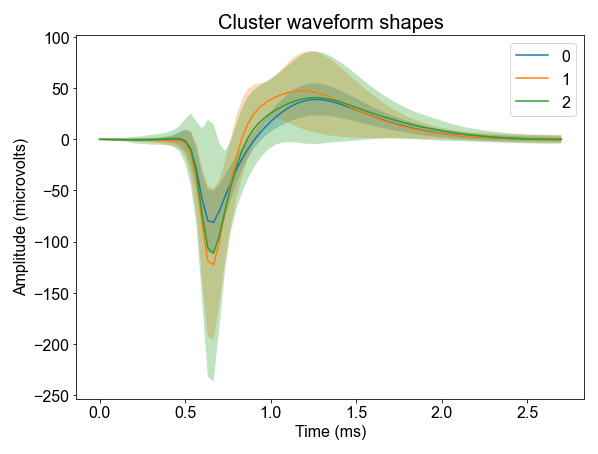

In [25]:
# plot waveform shapes together

plt.figure(figsize=(8,6))

for i, cluster in enumerate(clusters):
    
    clust_df = rwv_df[rwv_df['cluster_num'] == cluster]
    
    wvs = np.stack(clust_df['mean_wv_values']) # can easily be changed to plot all waveforms
    avg_wv = np.mean(wvs, axis=0)
    std = np.std(wvs, axis=0)
    t = clust_df['mean_wv_times'].iloc[0]
    
    plt.plot(t * 1000, avg_wv, label=cluster)
    plt.fill_between(t * 1000, avg_wv - std, avg_wv + std, alpha=0.3) # plot shaded standard dev
    

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
plt.title('Cluster waveform shapes')
plt.legend();

## Waveform Threshold Filtering

In [26]:
# add duration above (ms)
dur_threshold = 0.38

rwv_df['duration_above'] = (rwv_df['waveform_duration'] > dur_threshold).astype(int)

Cluster 1: 


	4 / 757 wt/wt positive units
	7 / 330 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	1 / 116 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 116 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units



Cluster 0: 


	4 / 166 wt/wt positive units
	9 / 64 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	15 / 32 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 17 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units





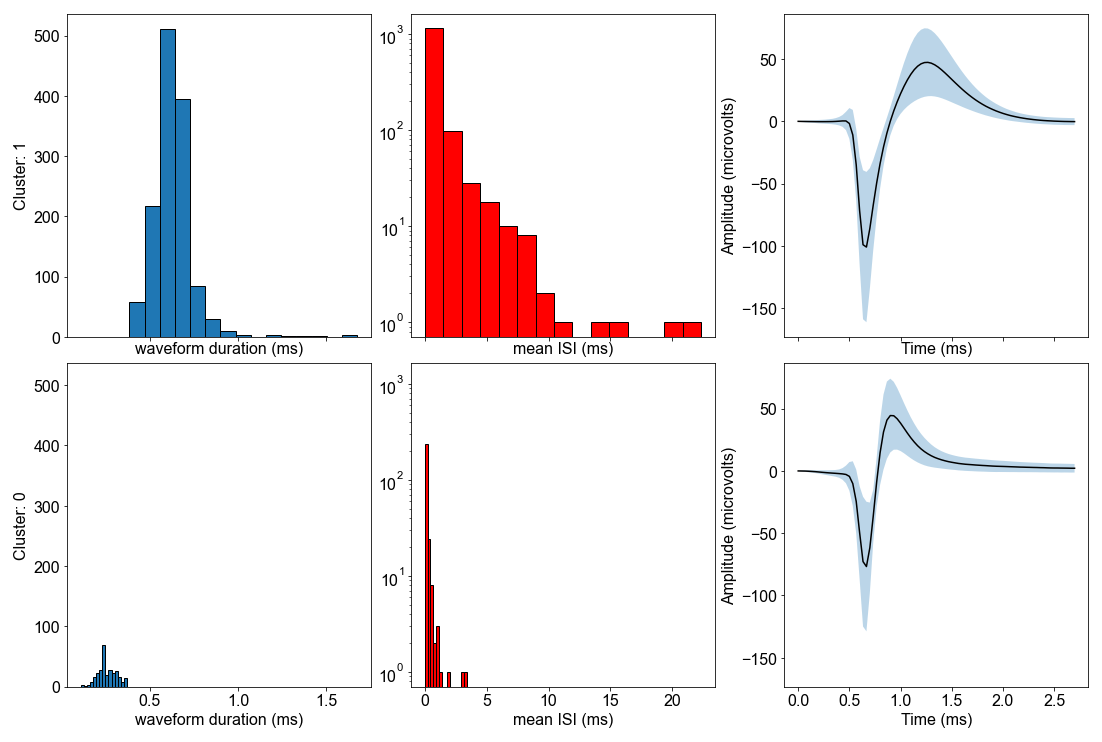

In [27]:
# for each cluster, visualize waveform_duration dist and count responsive units
clusters = rwv_df['duration_above'].unique()

fig, ax = plt.subplots(2,3, sharex='col', sharey='col', figsize=(15,10))

for i, cluster in enumerate(clusters):
    print(f'Cluster {cluster}: \n\n')
    
    clust_df = rwv_df[rwv_df['duration_above'] == cluster]
    
    # count number responded for each genotype
    genetic_resp(clust_df)
    
    # plot waveform_duration and mean ISI distribution
    ax[i, 0].hist(clust_df['waveform_duration'], edgecolor='black', bins=15)
    ax[i, 0].set_xlabel('waveform duration (ms)')
    
    ax[i, 1].hist(clust_df['mean_isi'], color= 'red', edgecolor='black', bins=15)
    ax[i, 1].set_xlabel('mean ISI (ms)')
    ax[i, 1].set_yscale('log')
    
    # compute avg waveform across units
    avg_wvf(clust_df, ax[i, 2])
    ax[i, 2].set_xlabel('Time (ms)')
    ax[i, 2].set_ylabel('Amplitude (microvolts)')
    
    ax[i, 0].set_ylabel(f"Cluster: {cluster}")
    
    print('\n\n')
    

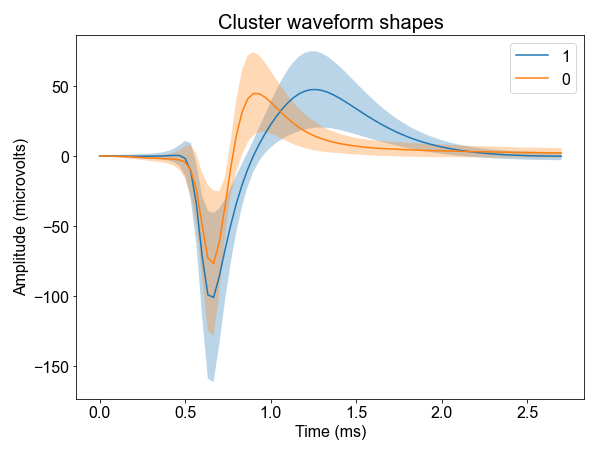

In [28]:
# plot waveform shapes together

plt.figure(figsize=(8,6))

for i, cluster in enumerate(clusters):
    
    clust_df = rwv_df[rwv_df['duration_above'] == cluster]
    
    wvs = np.stack(clust_df['mean_wv_values']) # can easily be changed to plot all waveforms
    avg_wv = np.mean(wvs, axis=0)
    std = np.std(wvs, axis=0)
    t = clust_df['mean_wv_times'].iloc[0]
    
    plt.plot(t * 1000, avg_wv, label=cluster)
    plt.fill_between(t * 1000, avg_wv - std, avg_wv + std, alpha=0.3) # plot shaded standard dev
    

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
plt.title('Cluster waveform shapes')
plt.legend();

## PCA 

In [29]:
X = rwv_df[waveform_features]
norm = StandardScaler()
X_norm = norm.fit_transform(X)

pca = PCA()
pca.fit(X_norm)

PCA()

In [30]:
pca.explained_variance_ratio_

array([0.37027745, 0.18918563, 0.12884656, 0.12004545, 0.11179057,
       0.05538789, 0.01951032, 0.00495612])

In [31]:
# Get the principal component loading vectors
loading_vectors = pca.components_

# Get the explained variance ratio of the first principal component
explained_variance_ratio = pca.explained_variance_ratio_[0]

# Get the names of the features (columns) in your dataset
feature_names = X.columns

# Calculate the contribution of each variable to the first principal component
contribution_to_first_component = pd.Series(loading_vectors[0], index=feature_names) * explained_variance_ratio

# Sort the contributions in descending order
contribution_to_first_component_sorted = contribution_to_first_component.abs().sort_values(ascending=False)

# Display the contributions
print(contribution_to_first_component_sorted)

waveform_repolarization_slope    0.204194
waveform_recovery_slope          0.193074
waveform_amplitude               0.179579
waveform_duration                0.091997
waveform_halfwidth               0.088249
waveform_spread                  0.073344
waveform_velocity_above          0.064704
waveform_velocity_below          0.008179
dtype: float64


In [32]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
variable,,,,,,,,
waveform_repolarization_slope,0.551462,0.160684,-0.067268,0.082226,-0.002933,-0.143600,-0.352633,-0.716802
waveform_velocity_above,-0.174744,0.319403,-0.169281,0.617042,-0.591112,0.326241,-0.043463,-0.017725
waveform_duration,-0.248453,0.642528,0.182586,-0.048689,-0.004030,-0.536129,0.417307,-0.167704
waveform_velocity_below,-0.022088,0.255253,-0.600172,-0.676319,-0.289272,0.181091,0.000752,-0.016498
waveform_halfwidth,-0.238331,0.435288,-0.084874,0.080354,0.690733,0.473305,-0.181736,-0.076837
waveform_spread,-0.198078,-0.230471,-0.729229,0.340495,0.253744,-0.441122,0.023156,-0.020618
waveform_recovery_slope,-0.521430,-0.003378,0.168637,-0.146555,-0.147955,-0.280814,-0.759881,-0.003862
waveform_amplitude,0.484986,0.389309,-0.076533,0.094067,0.059115,-0.235064,-0.297711,0.671669


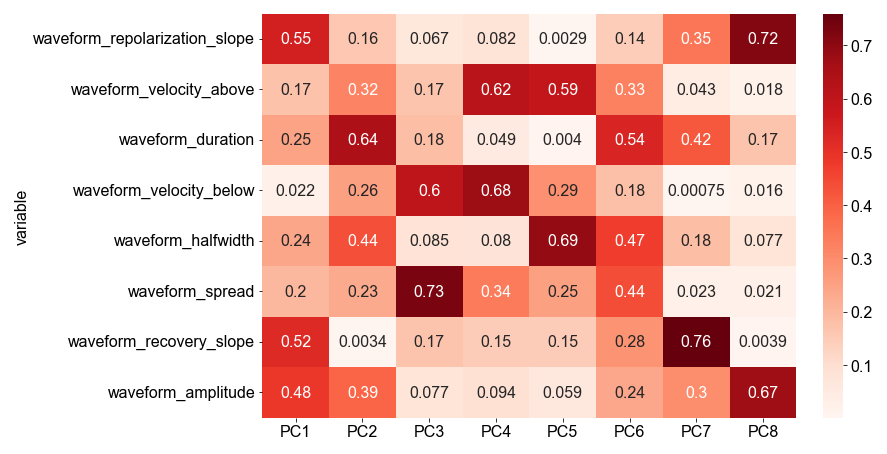

In [33]:
# get correlation matrix plot for loadings
plt.figure(figsize=(12,6))
ax = sns.heatmap(loadings_df.abs(), annot=True, cmap='Reds')
plt.show()

In [34]:
# transform data and apply GaussianMixture
z_vals = pca.transform(X_norm)
pc_label = [f'PC{i + 1}' for i in range(len(waveform_features))]
Z = pd.DataFrame(z_vals, columns=pc_label)

max_comp = 15
bics = []
for i in range(1, max_comp):
    
    clust_set['n_components'] = i
    gm = GaussianMixture(**clust_set)
    gm.fit(Z)
    
    bics.append(gm.bic(Z))

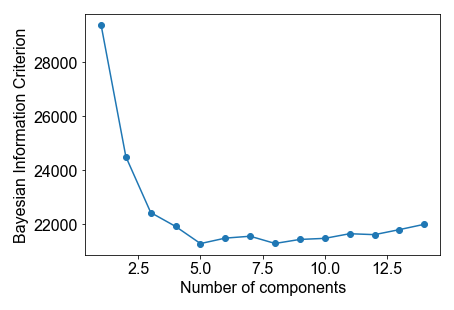

In [35]:
# plot BIC v # components
n_comp = range(1, max_comp)

plt.plot(n_comp, bics)
plt.scatter(n_comp, bics)

plt.xlabel('Number of components')
plt.ylabel('Bayesian Information Criterion');

In [36]:
# find minimum
n_comp = range(1, max_comp)
min_bic = n_comp[np.argmin(bics)]
print(f"Number of components with minimum BIC: {min_bic}")

Number of components with minimum BIC: 5


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

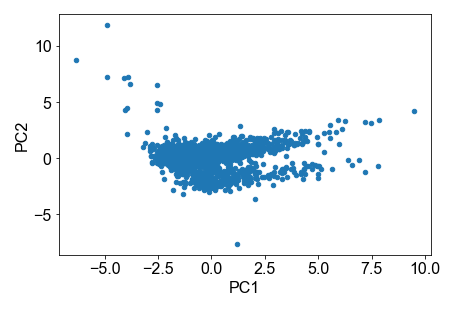

In [37]:
Z.plot(kind="scatter", x="PC1", y="PC2")

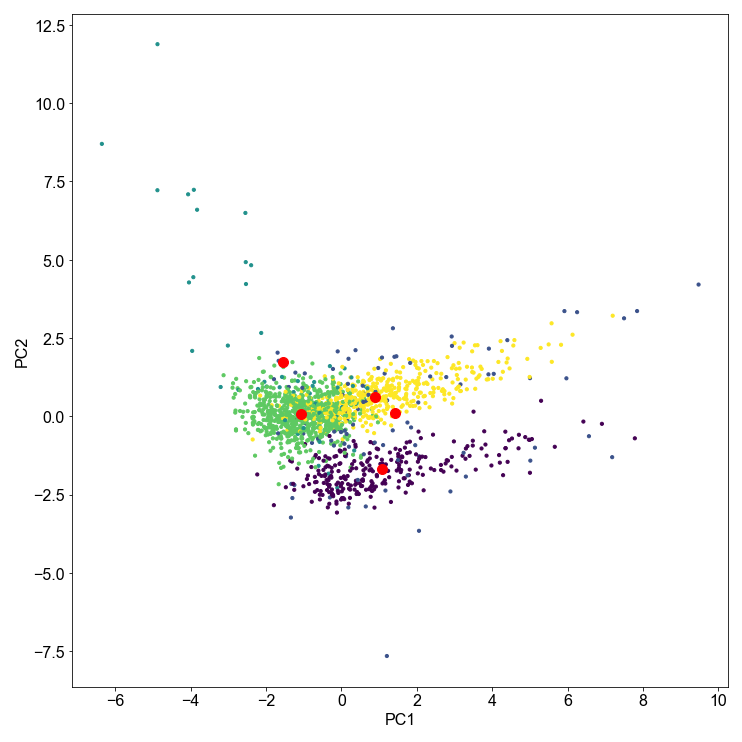

In [38]:
# fit with min_bic components
clust_set['n_components'] = 5 # min_bic
gm = GaussianMixture(**clust_set)
gm.fit(Z)
plot_clustering_results(Z, gm, idx_plt=[0, 1])

In [39]:
# add cluster_num to dataframe
pca_rwv_df = rwv_df.copy()

preds = gm.predict(Z)
pca_rwv_df['cluster_num'] = preds

Cluster 3: 


	1 / 456 wt/wt positive units
	5 / 177 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	2 / 58 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 43 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units



Cluster 2: 


	0 / 27 wt/wt positive units
	1 / 15 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 5 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 1 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units



Cluster 1: 


	1 / 48 wt/wt positive units
	0 / 19 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	1 / 12 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 18 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units



Cluster 0: 


	4 / 156 wt/wt positive units
	10 / 59 Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	13 / 31 Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt positive units
	0 / 15 Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP

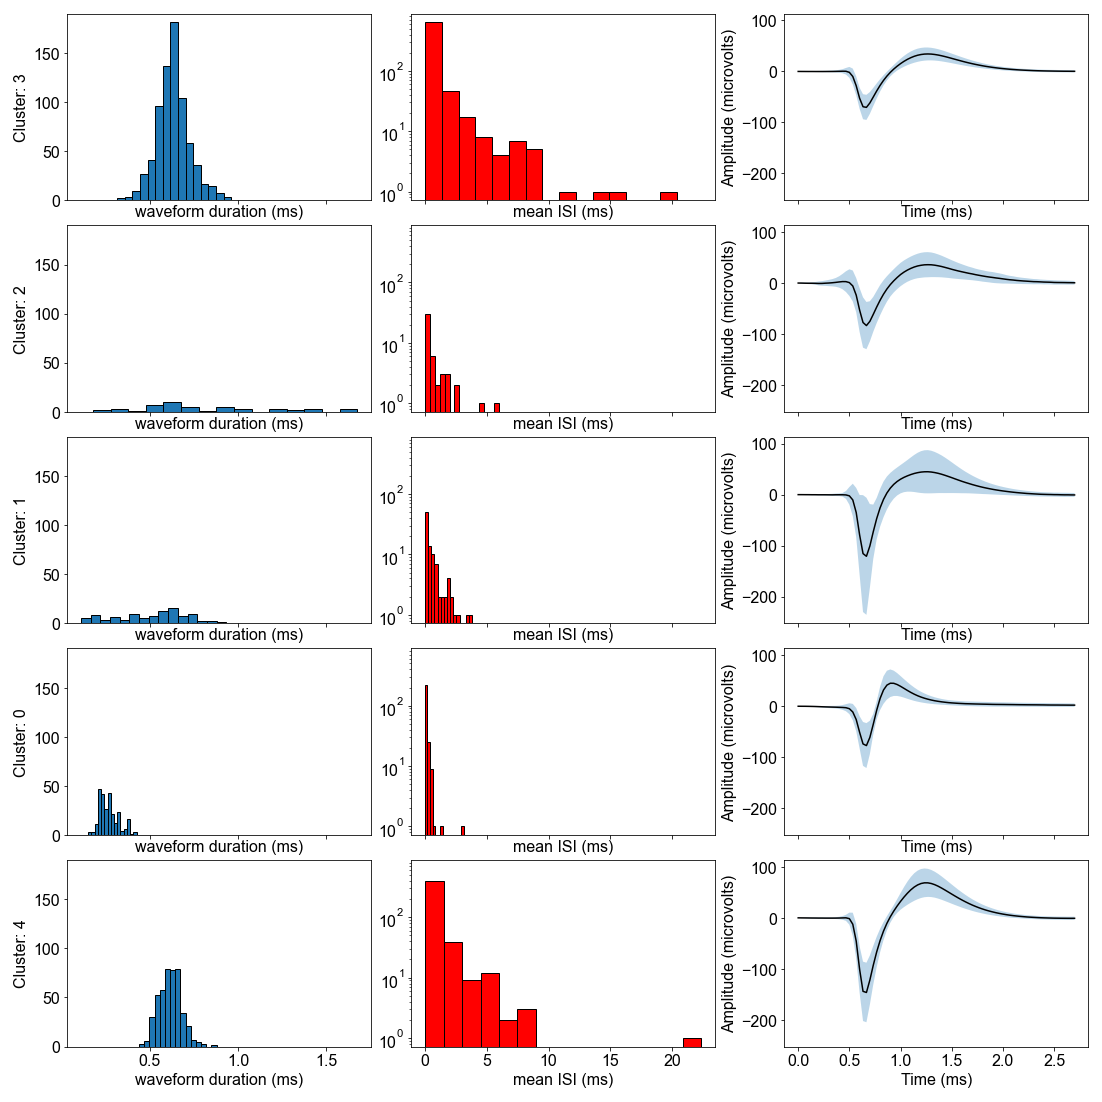

In [40]:
# for each cluster, visualize waveform_duration dist and count responsive units
clusters = pca_rwv_df['cluster_num'].unique()

fig, ax = plt.subplots(5,3, sharex='col', sharey='col', figsize=(15,15))

for i, cluster in enumerate(clusters):
    print(f'Cluster {cluster}: \n\n')
    
    clust_df = pca_rwv_df[pca_rwv_df['cluster_num'] == cluster]
    
    # count number responded for each genotype
    genetic_resp(clust_df)
    
    # plot waveform_duration and mean ISI distribution
    ax[i, 0].hist(clust_df['waveform_duration'], edgecolor='black', bins=15)
    ax[i, 0].set_xlabel('waveform duration (ms)')
    
    ax[i, 1].hist(clust_df['mean_isi'], color= 'red', edgecolor='black', bins=15)
    ax[i, 1].set_xlabel('mean ISI (ms)')
    ax[i, 1].set_yscale('log')
    
    # compute avg waveform across units
    avg_wvf(clust_df, ax[i, 2])
    ax[i, 2].set_xlabel('Time (ms)')
    ax[i, 2].set_ylabel('Amplitude (microvolts)')
    
    ax[i, 0].set_ylabel(f"Cluster: {cluster}")
    
    print('\n\n')
    

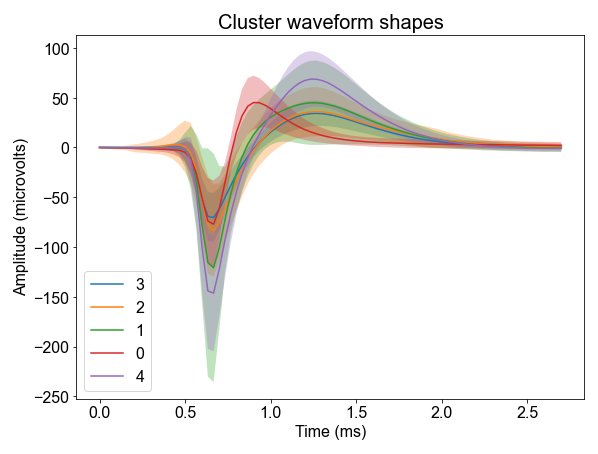

In [41]:
# plot waveform shapes together

plt.figure(figsize=(8,6))

for i, cluster in enumerate(clusters):
    
    clust_df = pca_rwv_df[pca_rwv_df['cluster_num'] == cluster]
    
    wvs = np.stack(clust_df['mean_wv_values']) # can easily be changed to plot all waveforms
    avg_wv = np.mean(wvs, axis=0)
    std = np.std(wvs, axis=0)
    t = clust_df['mean_wv_times'].iloc[0]
    
    plt.plot(t * 1000, avg_wv, label=cluster)
    plt.fill_between(t * 1000, avg_wv - std, avg_wv + std, alpha=0.3) # plot shaded standard dev
    

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
plt.title('Cluster waveform shapes')
plt.legend();

## Label specific cell types by Excitatory or Inhibitory

In [74]:
# cluster 0: inhib
# clusters 3, 4: excitatory
# else: undefined

In [69]:
labeled_units = pca_rwv_df[['session_id', 'unit_id', 'cluster_num']].copy()
labeled_units['cell_type'] = 'undefined'

# excitatory
labeled_units.loc[(labeled_units['cluster_num'] == 3) | (labeled_units['cluster_num'] == 4), 'cell_type'] = 'excitatory'

# inhibitory
labeled_units.loc[labeled_units['cluster_num'] == 0, 'cell_type'] = 'inhibitory'

labeled_units.drop(columns=['cluster_num'], inplace=True)

In [70]:
labeled_units['cell_type'].value_counts()

excitatory    1192
inhibitory     261
undefined      145
Name: cell_type, dtype: int64

In [72]:
labeled_units.head()

,session_id,unit_id,cell_type
0,771160300,950922446,excitatory
1,771160300,950922495,excitatory
2,771160300,950922511,undefined
3,771160300,950922546,excitatory
4,771160300,950922579,excitatory


In [73]:
#labeled_units.to_csv(f'{PROJECT_PATH}/data/optotagging_data/concat/cell_type_id_units.csv', index=False)